In [ ]:
#
# Scalling Analysis for the Flat Scan Sampling multi core
# João Inácio, Apr. 16th, 2021
# 
# old version -> n workers (used in the report)
# new version -> n workers, with shuffle
# both versions are included for comparison, use "old" for plots and "official" results
# 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress

In [2]:
# System and simulation information

dim = "2D"
lattice = "SS"
NN = 4

L = 16
N_atm = 1 * L**2

max_E = (1 / 2) * NN * N_atm
max_M = N_atm
NE = int(1 + (max_E / 2))
NM = N_atm + 1

REP = 10**5
skip = N_atm
shuffle = 10**0

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3

new_n_cores = np.array([1, 8, 16, 32, 64, 128, 256, 320])
old_n_cores = np.array([1, 8, 16, 32, 64, 128, 256, 320])


In [3]:
# Initialization of data arrays

new_wall_time = np.zeros(len(new_n_cores))
new_q_time_E = np.zeros(len(new_n_cores))

old_wall_time = np.zeros(len(old_n_cores))
old_q_time_E = np.zeros(len(old_n_cores))


In [4]:
# Get the data from the new implementation

k = 0
for n in new_n_cores:
    if n == 1:
        file_name = "".join(("./data_cluster/new_version/", str(int(n)), "_JDOS_FSS_Ising_", 
                             dim, "_", lattice, "_L", str(L), "_REP_1E", str(int(np.log10(REP))), 
                             "_skip_", str(skip)))
    else:
    
        file_name = "".join(("./data_cluster/new_version/", str(int(n)), "_JDOS_FSS_Ising_", 
                             dim, "_", lattice, "_L", str(L), "_REP_1E", str(int(np.log10(REP))), 
                             "_skip_", str(skip), "_shuffle_", str(int(np.log10(shuffle)))))

    with open(file_name + "_data.txt", 'r') as data_file:
        header = data_file.readline().strip("\n")

        q_time_E = np.zeros(q_max)
        for i in range(0, q_max):
            line = data_file.readline().strip("\n").split(" ")
            q_time_E[i] = float(line[4])

        new_wall_time[k] = float(data_file.readline().strip("\n"))
        new_q_time_E[k] = np.sum(q_time_E)
        
    k += 1


In [5]:
# Get the data from the old implementation

k = 0
for n in old_n_cores:
    if n == 1:
        file_name = "".join(("./data_cluster/old_version/", str(int(n)), "_JDOS_FSS_Ising_", 
                             dim, "_", lattice, "_L", str(L), "_REP_1E", str(int(np.log10(REP))), 
                             "_skip_", str(skip)))
    else:
    
        file_name = "".join(("./data_cluster/old_version/", str(int(n)), "_JDOS_FSS_Ising_", 
                             dim, "_", lattice, "_L", str(L), "_REP_1E", str(int(np.log10(REP))), 
                             "_skip_", str(skip)))

    with open(file_name + "_data.txt", 'r') as data_file:
        header = data_file.readline().strip("\n")

        q_time_E = np.zeros(q_max)
        for i in range(0, q_max):
            line = data_file.readline().strip("\n").split(" ")
            q_time_E[i] = float(line[4])

        old_wall_time[k] = float(data_file.readline().strip("\n"))
        old_q_time_E[k] = np.sum(q_time_E)

    k += 1


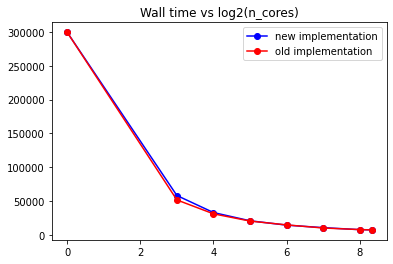

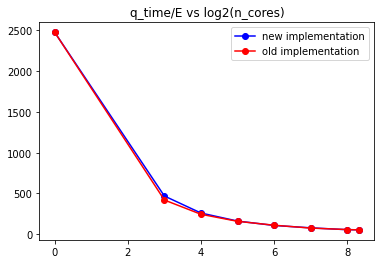

In [6]:
# Plot Wall time and q_time/E

# Wall time
plt.figure(1)
plt.plot(np.log2(new_n_cores), new_wall_time, '-ob', label='new implementation')
plt.plot(np.log2(old_n_cores), old_wall_time, '-or', label='old implementation')
plt.title("Wall time vs log2(n_cores)")
plt.legend()
    
# q_time/E
plt.figure(2)
plt.plot(np.log2(new_n_cores), new_q_time_E, '-ob', label='new implementation')
plt.plot(np.log2(old_n_cores), old_q_time_E, '-or', label='old implementation')
plt.title("q_time/E vs log2(n_cores)")
plt.legend()

plt.show()


In [7]:
# Estimation of p
# In this cell, we do the linear fit to Amdahl's Law
# Not used in the report, restuls are similar to taking the average of p

new_speedup = np.zeros(len(new_n_cores))
old_speedup = np.zeros(len(old_n_cores))

for i in range(len(new_n_cores)):
    new_speedup[i] = new_wall_time[0] / new_wall_time[i]

for i in range(len(old_n_cores)):
    old_speedup[i] = old_wall_time[0] / old_wall_time[i]
    
print("speedup: ")
print()

p_old_fit, intercept, r_value, p_value, std_err = linregress(1 / old_n_cores, 1 / old_speedup)
print("old implementation:", old_speedup)
print(f"linear fit with p={p_old_fit} and r2={r_value**2}")
print()

p_new_fit, intercept, r_value, p_value, std_err = linregress(1 / new_n_cores, 1 / new_speedup)
print("new implementation:", new_speedup)
print(f"linear fit with p={p_new_fit} and r2={r_value**2}")


speedup: 

old implementation: [ 1.          5.79571274  9.61830124 14.6492288  20.2767339  29.32671968
 38.12036402 40.70035473]
linear fit with p=0.9693589879019028 and r2=0.9990220894231218

new implementation: [ 1.          5.14486529  9.06641598 14.36546275 20.77311006 27.99695219
 38.69225124 39.84202144]
linear fit with p=0.9674968450130779 and r2=0.9973485073839011


In [8]:
# Estimation of p
# As it was described on the report, there are two ways of doing this analysis
# In this cell, we compute p for different core counts and take the average

p_old_i = (old_n_cores[1:] / (old_n_cores[1:] - 1)) * (1 - 1 / old_speedup[1:])
p_old_avg = np.mean(p_old_i)
print("old implementation:")
print("all p values for different core counts:", p_old_i)
print("mean(p_i):", p_old_avg)
print()

p_new_i = (new_n_cores[1:] / (new_n_cores[1:] - 1)) * (1 - 1 / new_speedup[1:])
p_new_avg = np.mean(p_new_i)
print("new implementation:")
print("all p values for different core counts:", p_new_i)
print("mean(p_i):", p_new_avg)


old implementation:
all p values for different core counts: [0.94566705 0.95576697 0.96179305 0.96577259 0.97350693 0.977586
 0.97848796]
mean(p_i): 0.9655115073547077

new implementation:
all p values for different core counts: [0.92072166 0.94901635 0.96040113 0.96696975 0.9718746  0.97797525
 0.97795699]
mean(p_i): 0.9607022463465994


old implementation:
linear fit with slope=-2369.86, intercept=47.78 and r2=0.9961756976877185
p=0.979068554298476

new implementation:
linear fit with slope=-2595.03, intercept=48.35 and r2=0.9953756833900481
p=0.9793176443438704


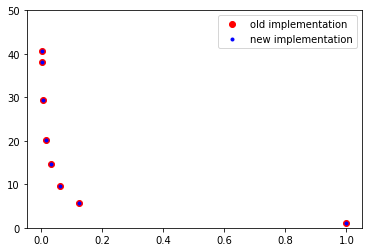

In [9]:
# Estimation of p
# As it was described on the report, there are two ways of doing this analysis
# In this cell, we do the extrapolation to n=$\infty$

plt.figure(1)
plt.plot(1/old_n_cores, old_speedup, 'or', label="old implementation")
plt.plot(1/old_n_cores, old_speedup, '.b', label="new implementation")
plt.ylim([0, 50])

plt.legend()


# Taking the last 3 values where there is a linear relation
slope, intercept, r_value, p_value, std_err = linregress(1 / old_n_cores[5:], old_speedup[5:])
p_old_extrap = 1 - 1 / intercept
print("old implementation:")
print(f"linear fit with slope={slope:.2f}, intercept={intercept:.2f} and r2={r_value**2}")
print(f"p={p_old_extrap}")
print()

# Taking the last 3 values where there is a linear relation
slope, intercept, r_value, p_value, std_err = linregress(1 / old_n_cores[5:], new_speedup[5:])
p_new_extrap = 1 - 1 / intercept
print("new implementation:")
print(f"linear fit with slope={slope:.2f}, intercept={intercept:.2f} and r2={r_value**2}")
print(f"p={p_new_extrap}")


In [10]:
# Final p values for every method

p_old_fit = np.round(p_old_fit, decimals=2)
p_old_avg = np.round(p_old_avg, decimals=2)
p_old_extrap = np.round(p_old_extrap, decimals=2)

p_new_fit = np.round(p_new_fit, decimals=2)
p_new_avg = np.round(p_new_avg, decimals=2)
p_new_extrap = np.round(p_new_extrap, decimals=2)

print(f"p_old_fit: {p_old_fit}")
print(f"p_old_avg: {p_old_avg}")
print(f"p_old_extrap: {p_old_extrap}")
print()

print(f"p_new_fit: {p_new_fit}")
print(f"p_new_avg: {p_new_avg}")
print(f"p_new_extrap: {p_new_extrap}")


p_old_fit: 0.97
p_old_avg: 0.97
p_old_extrap: 0.98

p_new_fit: 0.97
p_new_avg: 0.96
p_new_extrap: 0.98


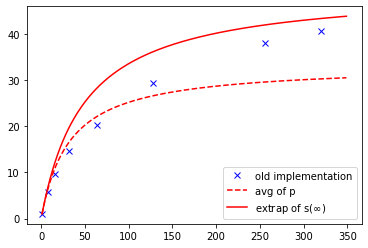

In [11]:
# Amdahl's Law plot for old implementation
# Plots used in the report

cores_amd = np.arange(1, 350, 1)

old_speedup_avg = 1 / (1 - p_old_avg + (p_old_avg / cores_amd))
old_speedup_extrap = 1 / (1 - p_old_extrap + (p_old_extrap / cores_amd))

plt.figure(1)

plt.plot(old_n_cores, old_speedup, 'xb', label='old implementation')
plt.plot(cores_amd, old_speedup_avg, '--r', label='avg of p')
plt.plot(cores_amd, old_speedup_extrap, '-r', label=r'extrap of s($\infty$)')
plt.legend()

plt.show()


In [17]:
# Writes #cores and speedup for old implementation
with open("./old_speedup_points.txt", 'w') as file:
    for i in range(len(old_n_cores)):
        file.write(f"{old_n_cores[i]} {old_speedup[i]}\n")

# Writes lines of speedup(#cores) for old implementation
with open("./old_speeduo_lines.txt", 'w') as file:
    for i in range(len(cores_amd)):
        file.write(f"{cores_amd[i]} {old_speedup_avg[i]} {old_speedup_extrap[i]}\n")
